<a href="https://colab.research.google.com/github/gabrielealberto/VaR/blob/main/Historic_VaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

In [15]:
years = 15
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=252*years)

In [16]:
etf = ['EXS1.DE', 'CSMIB.MI', 'SXRW.DE', 'CSSPX']

# Download data and create DataFrame with Close prices only
df = pd.DataFrame()

for ticker in etf:
    data = yf.download(ticker, start=startDate, end=endDate, interval='1d', auto_adjust=True)
    df[ticker] = data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [17]:
df.head(5)

,EXS1.DE,CSMIB.MI,SXRW.DE,CSSPX
Date,,,,
2015-05-26,102.970001,79.190002,133.720001,34.990788
2015-05-27,104.150002,81.089996,134.820007,35.177975
2015-05-28,103.209999,80.769997,133.820007,34.957359
2015-05-29,100.980003,80.220001,132.220001,34.676571
2015-06-01,101.099998,79.809998,131.320007,34.830345


In [18]:
log_rets=np.log(df/df.shift(1)).dropna()

In [19]:
# Portfolio parameters
value = 100000
alpha = 0.05
days = 7
weights = len(etf) * [1/len(etf)]

In [20]:
# Calculate portfolio returns
portfolio_returns = log_rets.dot(weights)

In [21]:
# Calculate N-day returns (non-overlapping periods)
# This is the correct approach: reshape into consecutive N-day periods
n_periods = len(portfolio_returns) // days
trimmed_returns = portfolio_returns[:n_periods * days]
x_day_returns = trimmed_returns.values.reshape(-1, days).sum(axis=1)

In [22]:
# Convert to absolute monetary values
x_day_returns_abs = x_day_returns * value

In [23]:
# Calculate VaR and CVaR in absolute terms
VaR_hist = np.percentile(x_day_returns_abs, 100*alpha)
CVaR_hist = x_day_returns_abs[x_day_returns_abs <= VaR_hist].mean()

print(f'Portfolio Value: €{value}')
print(f'VaR {days} days: €{VaR_hist:.2f}')
print(f'CVaR {days} days: €{CVaR_hist:.2f}')

Portfolio Value: €100000
VaR 7 days: €-3833.73
CVaR 7 days: €-7284.83


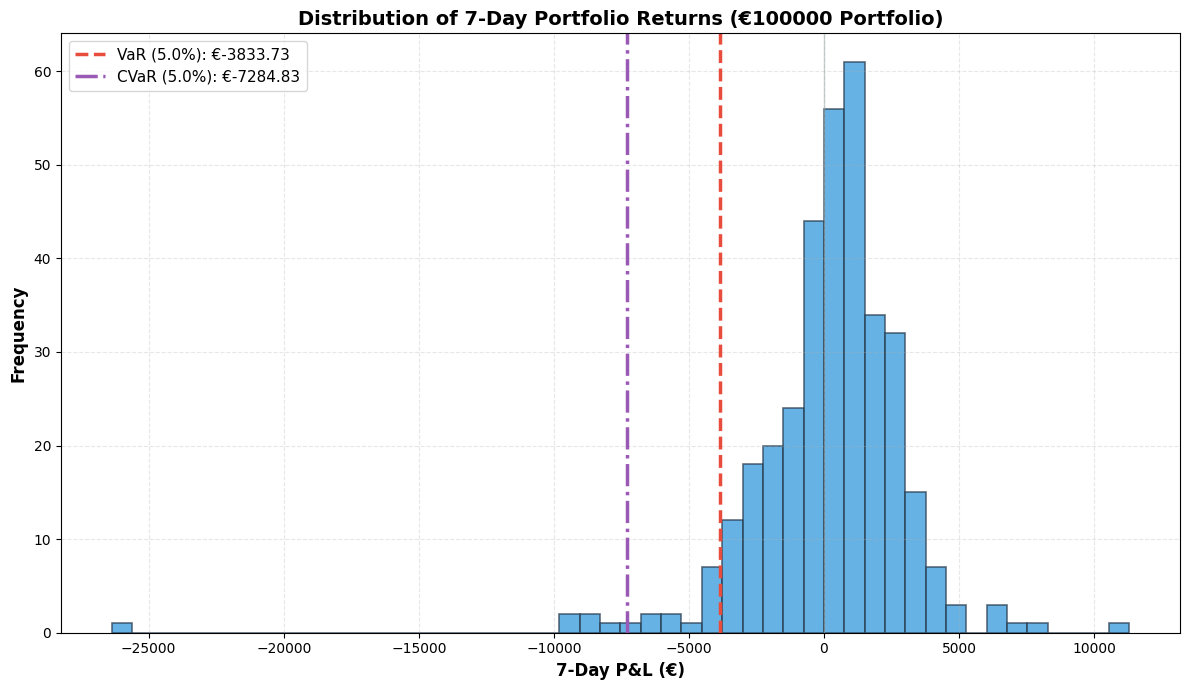

In [24]:
# Visualization
plt.figure(figsize=(12, 7))
plt.hist(x_day_returns_abs, bins=50, alpha=0.75, color='#3498db', edgecolor='#2c3e50', linewidth=1.2)
plt.axvline(VaR_hist, color='#e74c3c', linestyle='--', linewidth=2.5, label=f'VaR ({alpha*100}%): €{VaR_hist:.2f}')
plt.axvline(CVaR_hist, color='#9b59b6', linestyle='-.', linewidth=2.5, label=f'CVaR ({alpha*100}%): €{CVaR_hist:.2f}')
plt.axvline(0, color='#95a5a6', linestyle='-', linewidth=1, alpha=0.5)
plt.xlabel(f'{days}-Day P&L (€)', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title(f'Distribution of {days}-Day Portfolio Returns (€{value} Portfolio)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()